In [1]:
from multiprocessing import Pool

import EEGAnalysis as ea
import h5py
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import re, os
from tqdm import tqdm

In [2]:
dataset = ea.DataManager('/home/yizhan/storage/EEG/Data')

patient_id = 'zhouchen'
patient = dataset.get_patient(patient_id)

In [3]:
# contants
_freq = 2000
ROI = (-4, 4)
tspec = np.linspace(ROI[0],ROI[1],_freq * (ROI[1] - ROI[0]))

nyq = _freq / 2.0
width = 5.0 / nyq
ripple_db = 60.0

# Compute the order and Kaiser parameter for the FIR filter.
N, beta = signal.kaiserord(ripple_db, width)

taps = signal.firwin(N, [4/nyq, 8/nyq],window=('kaiser', beta),pass_zero=False)

In [6]:
chidx = 99
data_list = patient.load_isplit(chidx)
data_list.keys()

dict_keys(['180827-1', '180827-2', '180827-3', '180829-1', '180829-2', '180829-3', '180831-1', '180831-2', '180831-3', '180901-1', '180901-2', '180901-3', '180902-1', '180902-2', '180902-3', '180903-1', '180903-2', '180903-3', '180904-1', '180904-2', '180904-3'])

In [7]:
# _m = patient.get_marker('180901-1', paradigm='1-5')
# _sample = data_list['180901-1']['value']

# _filted = signal.hilbert(signal.filtfilt(taps, 1, _sample))
# _epoch = ea.create_1d_epoch_bymarker(_filted, _m, ROI, int(_freq))

_temp = []
for idate in tqdm(data_list.keys()):
    if idate[-1] != '1' or idate in ['190108-1', '190109-1']:
        continue

    _m = patient.get_marker(idate, paradigm='1-5')
    _entry = data_list[idate]['value']
    _filted = signal.hilbert(signal.filtfilt(taps, 1, _entry))
    _epoch = ea.create_1d_epoch_bymarker(_filted, _m, ROI, int(_freq))
    _temp.append(_epoch)
    
_temp = np.array(_temp)

In [11]:
_temp[:, 0:5, :].reshape((35, -1)).shape

(35, 16000)

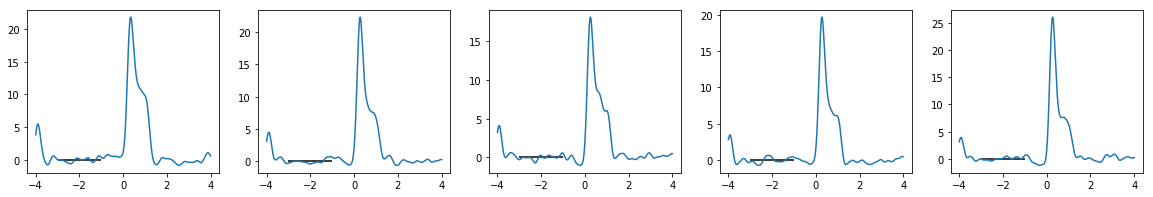

In [12]:
n = 5

plt.figure(figsize=(4*n, 3))
for i in range(n):
    _pwr = ea.decomposition.dwt_power([_temp[:, i*(20//n):(i+1)*(20//n), :].reshape((7*20//n, -1))], _freq, baseline=(1,3))
    _curve = ea.filter.gaussianwind(_pwr[0], int(_freq), 0.1)
    
    plt.subplot(1, n, i+1)
    plt.plot(tspec, _curve)
    plt.hlines([0], 1-4, 3-4)
plt.show()

In [5]:
def _plot_zhouchen(chidx):
    data_list = patient.load_isplit(chidx)
    
    _temp = []
    for idate in data_list.keys():
        if idate[-1] != '1' or idate in ['190108-1', '190109-1']:
            continue

        _m = patient.get_marker(idate, paradigm='1-5')
        _entry = data_list[idate]['value']
        _filted = signal.hilbert(signal.filtfilt(taps, 1, _entry))
        _epoch = ea.create_1d_epoch_bymarker(_filted, _m, ROI, int(_freq))
        _temp.append(_epoch)

    _temp = np.array(_temp)

    n = 5

    plt.figure(figsize=(4*n, 3))
    for i in range(n):
        _pwr = ea.decomposition.dwt_power([_temp[:, i*(20//n):(i+1)*(20//n), :].reshape((7*20//n, -1))], _freq, baseline=(1,3))
        _curve = ea.filter.gaussianwind(_pwr[0], int(_freq), 0.05)

        plt.subplot(1, n, i+1)
        plt.plot(tspec, _curve)
        plt.hlines([0], 1-4, 3-4)
    
    plt.suptitle('channel %d'%chidx)
#     plt.show()
    plt.savefig('Stim_latency_export/%s_theta_s5/channel-%d.png'%(patient_id, chidx), bbox_inches='tight')
    plt.close()

100%|██████████| 21/21 [00:28<00:00,  1.33s/it]


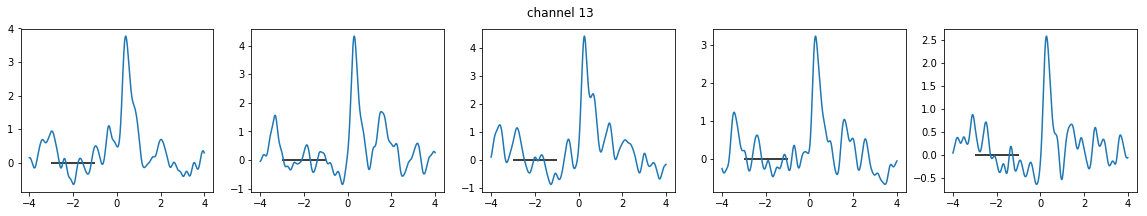

In [17]:
_plot_zhouchen(13)

In [6]:
with Pool(15) as p:
    max_ = 110
    a = list(tqdm(p.imap_unordered(_plot_zhouchen, range(max_)), total=max_))

100%|██████████| 110/110 [22:21<00:00,  3.15s/it] 


In [9]:
for i in tqdm(range(110)):
    _plot_zhouchen(i)

 15%|█▍        | 16/110 [07:09<41:59, 26.80s/it]

KeyboardInterrupt: 